## Load Data and Initial Grid Search

In [13]:
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = HANNAH
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'toy-agriVision-blue-fourier'
GROUP = 'band'
SKIP_OPTIMIZE_STEP = True
CONSTANT_SAMPLE_SIZE = float('inf')
MIN_GROUP, MAX_GROUP = 2, 14 
# Should be 2, (8 or 9) if wavelet; 2, 14 if fourier. 
# Inspect data_df and decide based on minimum and maximum values of layers/bands
# Discard Layer 1 / Band 1

''' Only need to run commented code (3 lines) below once'''
os.mkdir(DATA_NAME)
os.mkdir(os.path.join(DATA_NAME, "CSVs"))
os.mkdir(os.path.join(DATA_NAME, "plots"))

In [6]:
from utilities import *
from plot_utilities import *

''' Uncomment if you need to compute prior CDFs or PDFs using MATLAB'''
# import matlab.engine 
# eng = matlab.engine.connect_matlab()

data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
data_df[GROUP].apply([min, max])

min     1
max    14
Name: band, dtype: int64

In [7]:
''' Only need to run commented code (6 lines) below once'''
min_group, max_group = MIN_GROUP, MAX_GROUP
group_data_map = dict()
for group in np.arange(min_group, max_group + 1):
    data = data_df[(data_df[GROUP] == group)]['data'].iloc[0]
    group_data_map[group] = np.sort(data) # [np.unique(np.round(np.linspace(0, data.size - 1, min(CONSTANT_SAMPLE_SIZE, data.size))).astype(int))] 
pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
group_data_map

{2: array([-290806.1467721 , -279747.74751633]),
 3: array([-385507.44567086, -303407.3225798 ]),
 4: array([-302286.13540087, -257729.34581713]),
 5: array([-292634.25651578, -147678.49909753]),
 6: array([-211248.56166239, -182095.31015853]),
 7: array([-210501.13169756, -158765.27064439]),
 8: array([-163427.32901689,  -95845.09545928]),
 9: array([-95106.8664077 , -68720.73655119]),
 10: array([-88000.17697352, -73462.72392406]),
 11: array([-571804.71153928, -147198.66072935]),
 12: array([-305283.9802674 , -278621.12182885]),
 13: array([-169392.83185405, -101050.25559402]),
 14: array([-29955.11781428, -23330.50650377])}

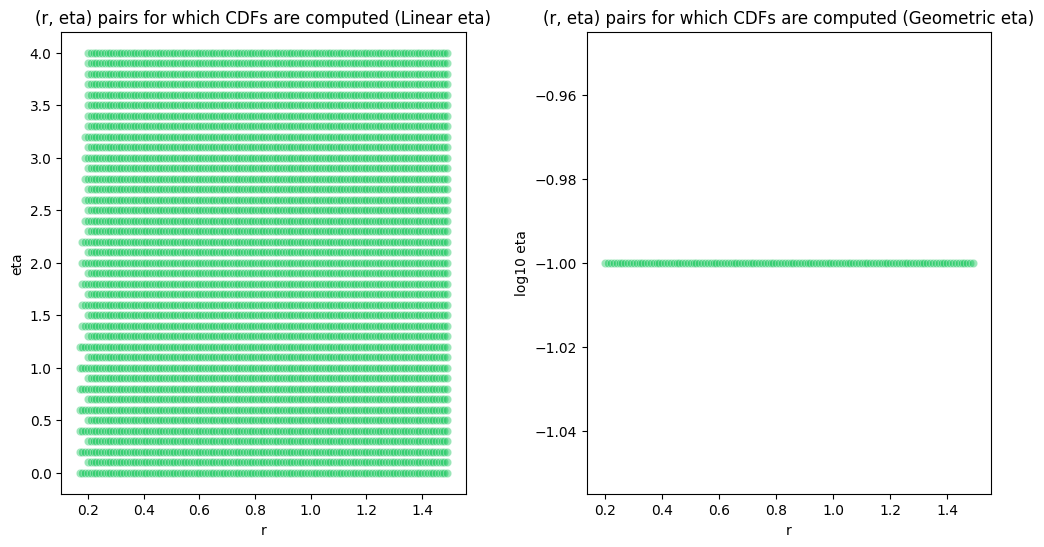

,"(r,eta),cdf",r,eta,cdf
0,"((0.17, 0), <scipy.interpolate._cubic.CubicSpl...",0.17,0.0,<scipy.interpolate._cubic.CubicSpline object a...
1,"((0.17, 0.2), <scipy.interpolate._cubic.CubicS...",0.17,0.2,<scipy.interpolate._cubic.CubicSpline object a...
2,"((0.17, 0.4), <scipy.interpolate._cubic.CubicS...",0.17,0.4,<scipy.interpolate._cubic.CubicSpline object a...
3,"((0.17, 0.6), <scipy.interpolate._cubic.CubicS...",0.17,0.6,<scipy.interpolate._cubic.CubicSpline object a...
4,"((0.17, 0.8), <scipy.interpolate._cubic.CubicS...",0.17,0.8,<scipy.interpolate._cubic.CubicSpline object a...
...,...,...,...,...
5361,"((1.49, 3.6), <scipy.interpolate._cubic.CubicS...",1.49,3.6,<scipy.interpolate._cubic.CubicSpline object a...
5362,"((1.49, 3.7), <scipy.interpolate._cubic.CubicS...",1.49,3.7,<scipy.interpolate._cubic.CubicSpline object a...
5363,"((1.49, 3.8), <scipy.interpolate._cubic.CubicS...",1.49,3.8,<scipy.interpolate._cubic.CubicSpline object a...
5364,"((1.49, 3.9), <scipy.interpolate._cubic.CubicS...",1.49,3.9,<scipy.interpolate._cubic.CubicSpline object a...


In [8]:
# Omitted scipy_10000 CDFs because all best-fit CDFs were around r = 0.2
all_cdfs = combine_pickles('mtlb_10000') | combine_pickles('mtlb_100000') # | combine_pickles('scipy_10000')
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

all_cdfs_df.sort_values(['r', 'eta'])

In [9]:
''' Only need to run commented code once'''

master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Processing group (layer/band) ", group)
    sample = group_data_map[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
    ksstats_eta0 = [ksstats[i] for i in idx_eta0]
    idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
    master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
master_df = master_df.set_index(GROUP)
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

Processing group (layer/band)  2
Processing group (layer/band)  3
Processing group (layer/band)  4
Processing group (layer/band)  5
Processing group (layer/band)  6
Processing group (layer/band)  7
Processing group (layer/band)  8
Processing group (layer/band)  9
Processing group (layer/band)  10
Processing group (layer/band)  11
Processing group (layer/band)  12
Processing group (layer/band)  13
Processing group (layer/band)  14


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0
band,,,,,
2,2,"(0.2, 0.9)",1.0,"(0.21, 0)",1.0
3,2,"(0.2, 0.9)",1.0,"(0.17, 0)",1.0
4,2,"(0.2, 0.9)",1.0,"(0.19, 0)",1.0
5,2,"(0.2, 0.6)",1.0,"(0.17, 0)",1.0
6,2,"(0.2, 0.7)",1.0,"(0.2, 0)",1.0
7,2,"(0.2, 0.6)",1.0,"(0.2, 0)",1.0
8,2,"(0.17, 0.0)",1.0,"(0.17, 0)",1.0
9,2,"(0.34, 0.0)",1.0,"(0.34, 0)",1.0
10,2,"(0.17, 0.0)",1.0,"(0.17, 0)",1.0


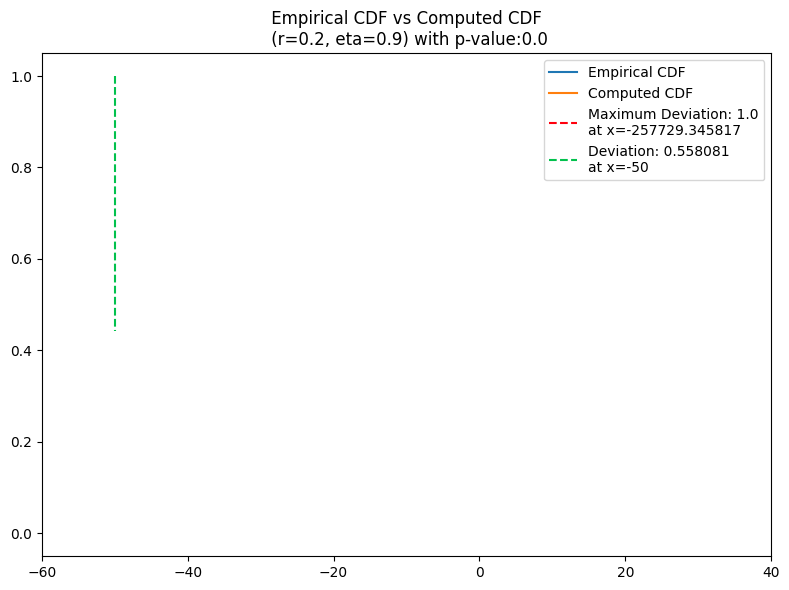

In [10]:
group = 4
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-60, 40), 
              provided_loc = -50);

In [11]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = group_data_map[group].size
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05
band,,,,,,
2,2,"(0.2, 0.9)",1.0,"(0.21, 0)",1.0,0.841886
3,2,"(0.2, 0.9)",1.0,"(0.17, 0)",1.0,0.841886
4,2,"(0.2, 0.9)",1.0,"(0.19, 0)",1.0,0.841886
5,2,"(0.2, 0.6)",1.0,"(0.17, 0)",1.0,0.841886
6,2,"(0.2, 0.7)",1.0,"(0.2, 0)",1.0,0.841886
7,2,"(0.2, 0.6)",1.0,"(0.2, 0)",1.0,0.841886
8,2,"(0.17, 0.0)",1.0,"(0.17, 0)",1.0,0.841886
9,2,"(0.34, 0.0)",1.0,"(0.34, 0)",1.0,0.841886
10,2,"(0.17, 0.0)",1.0,"(0.17, 0)",1.0,0.841886


In [12]:
r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized
SKIP_OPTIMIZE_STEP = SKIP_OPTIMIZE_STEP

if SKIP_OPTIMIZE_STEP:
    r_d, eta_d = 2, 1
    master_df['kstest_stat_cd'] = master_df['kstest_stat_initial']
    master_df[f'best_r_d{r_d}'] = master_df['initial_param'].apply(lambda x : x[0])
    master_df[f'best_eta_d{eta_d}'] = master_df['initial_param'].apply(lambda x : x[1])

else:
    for group in np.arange(min_group, max_group+1): 
        sample = group_data_map[group]
        initial_param = master_df.loc[group, 'initial_param']
        master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, 
                                                                                                                    r_depth = r_d, eta_depth=eta_d, 
                                                                                                                    scipy_int=False, group=group, 
                                                                                                                    eng=eng, DATA_NAME=DATA_NAME)
        master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{DATA_NAME}_group{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
        print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")


master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

ZeroDivisionError: float division by zero

## Comparing Empirical and Computed CDF/PDF

Chebyshev bound: 142.377113752867
First CDF value: 3.995114116092164e-12
Last CDF value: 0.9969749647558226
0, 1 padding bounds: 1000000.0


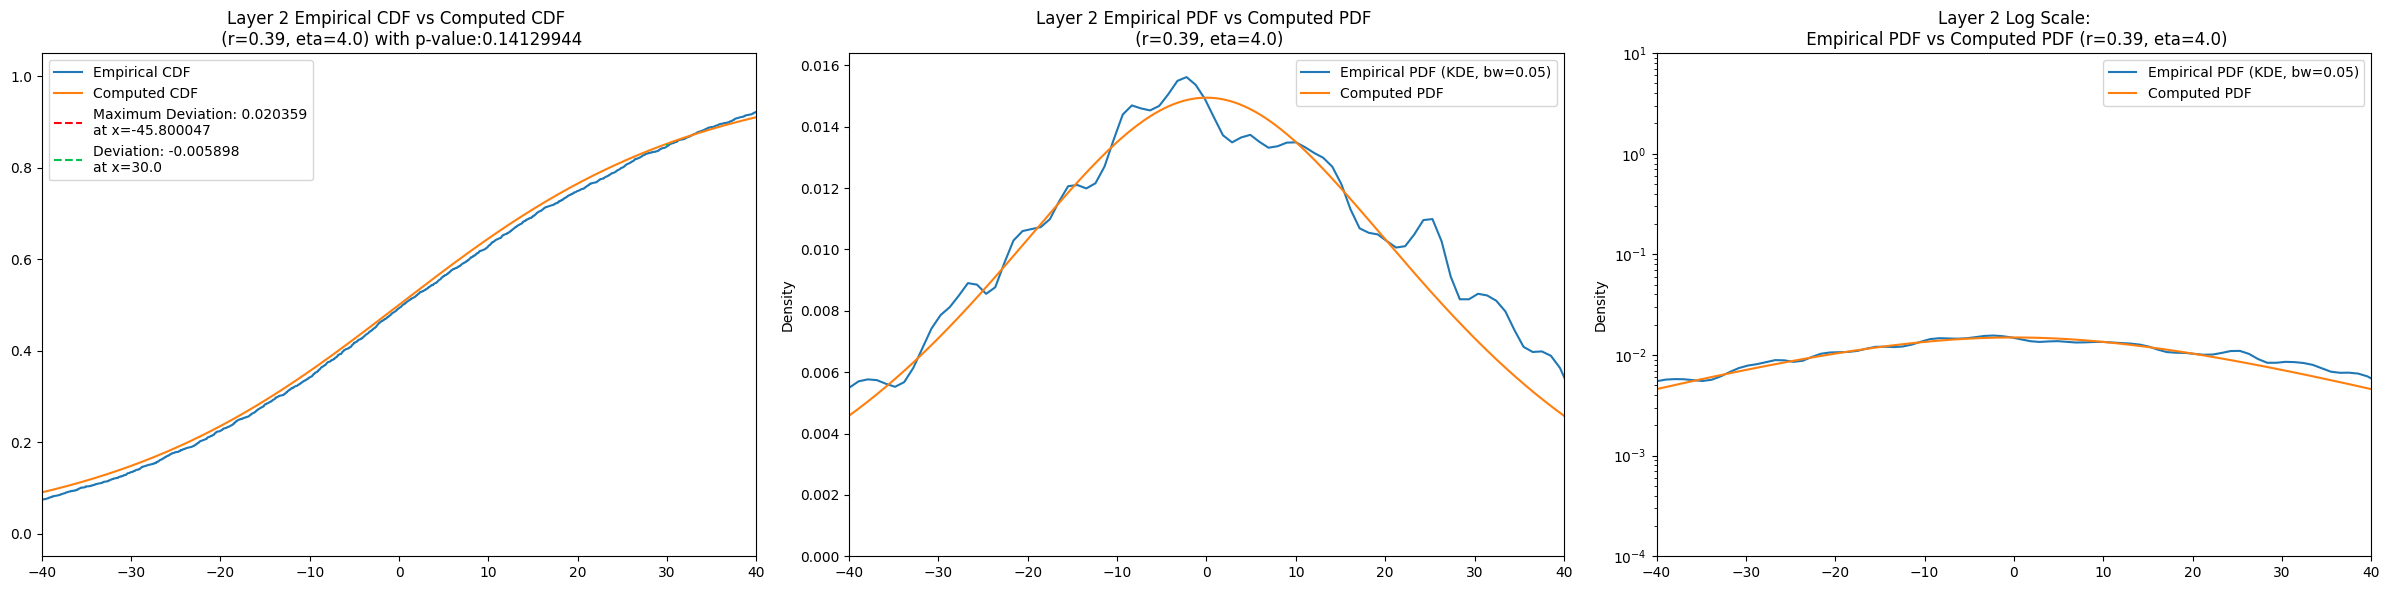

No tail
Chebyshev bound: 78.46081890770525
First CDF value: 5.507148241361813e-07
Last CDF value: 0.9992916761941001
0, 1 padding bounds: 1000000.0


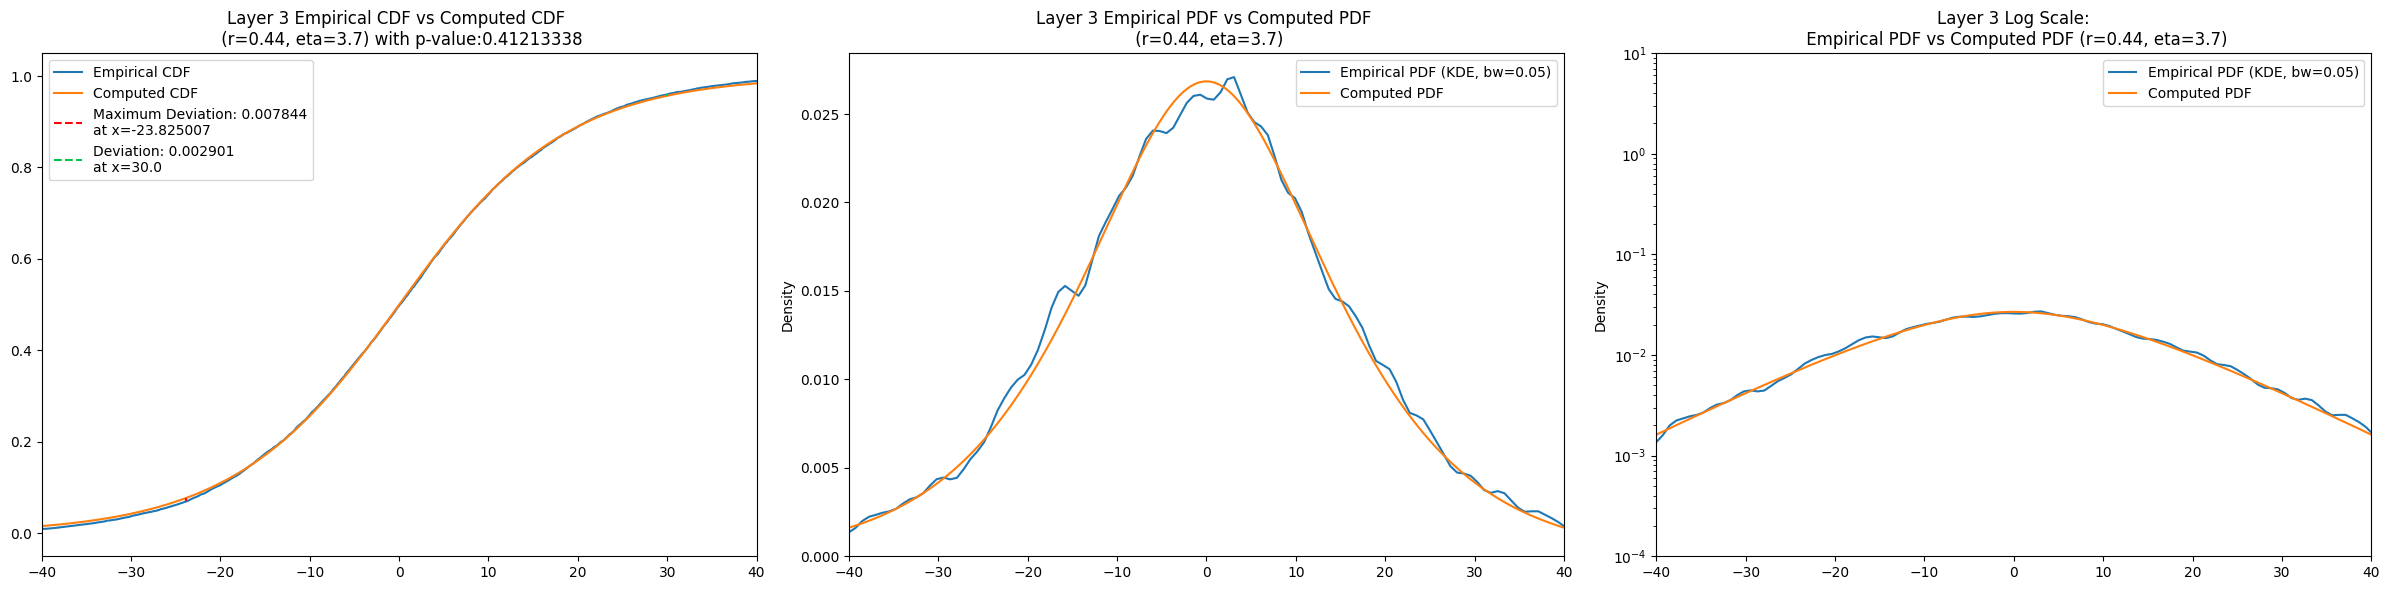

No tail
Chebyshev bound: 42.167304052604024
First CDF value: 9.697496609613425e-07
Last CDF value: 0.9984281058333783
0, 1 padding bounds: 1000000.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


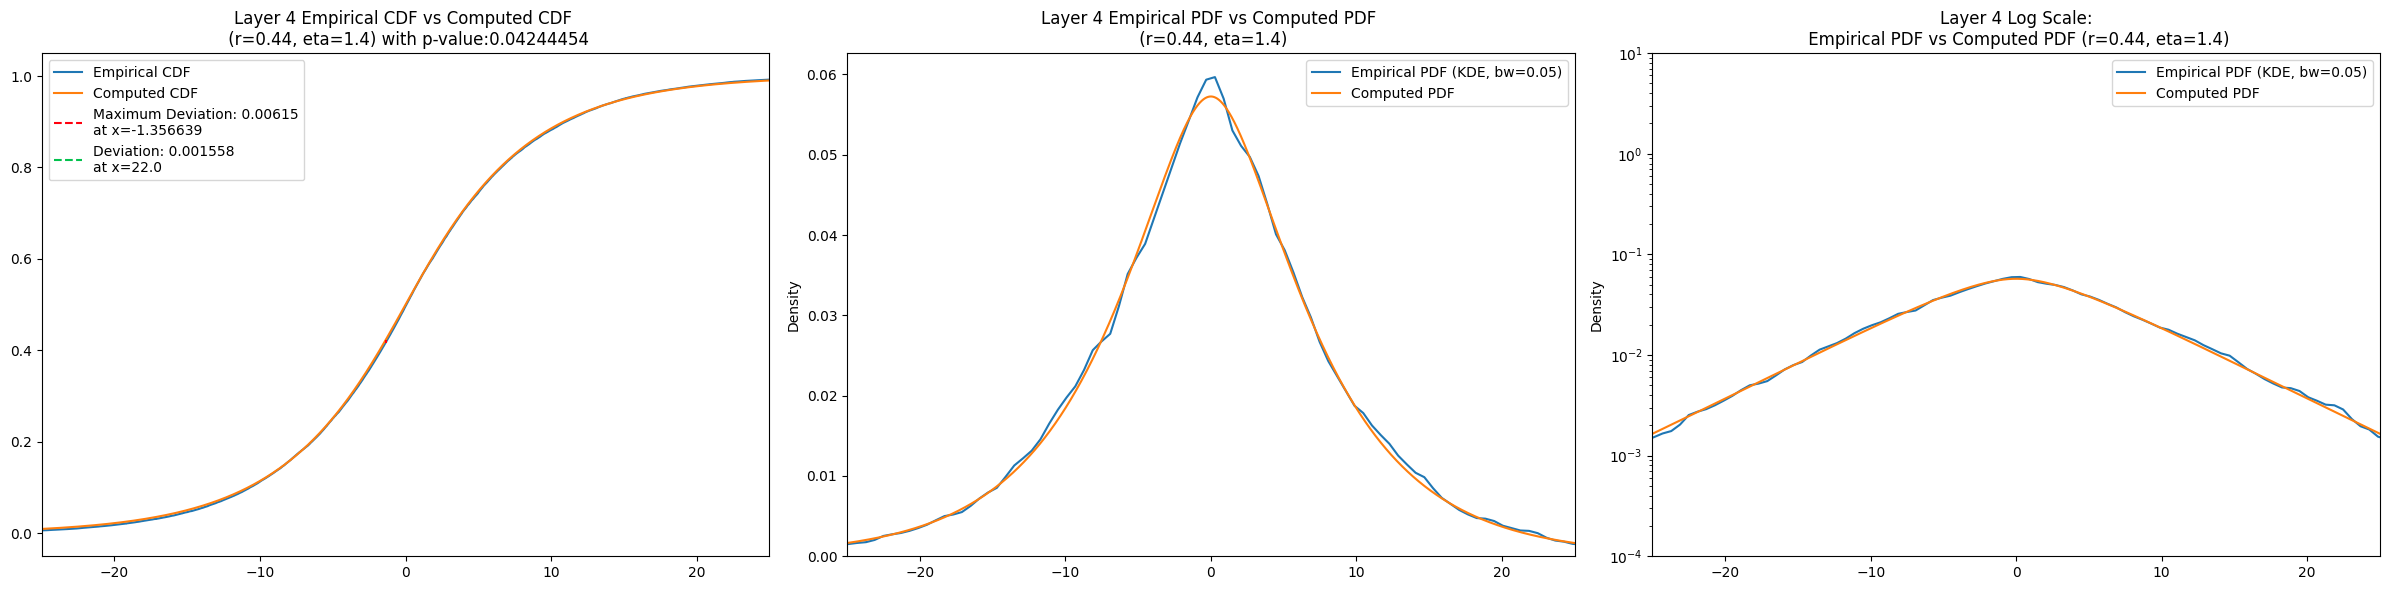

No tail
Chebyshev bound: 20.300820925496282
First CDF value: 1.3849825754018901e-06
Last CDF value: 0.9973242174031235
0, 1 padding bounds: 1000000.0


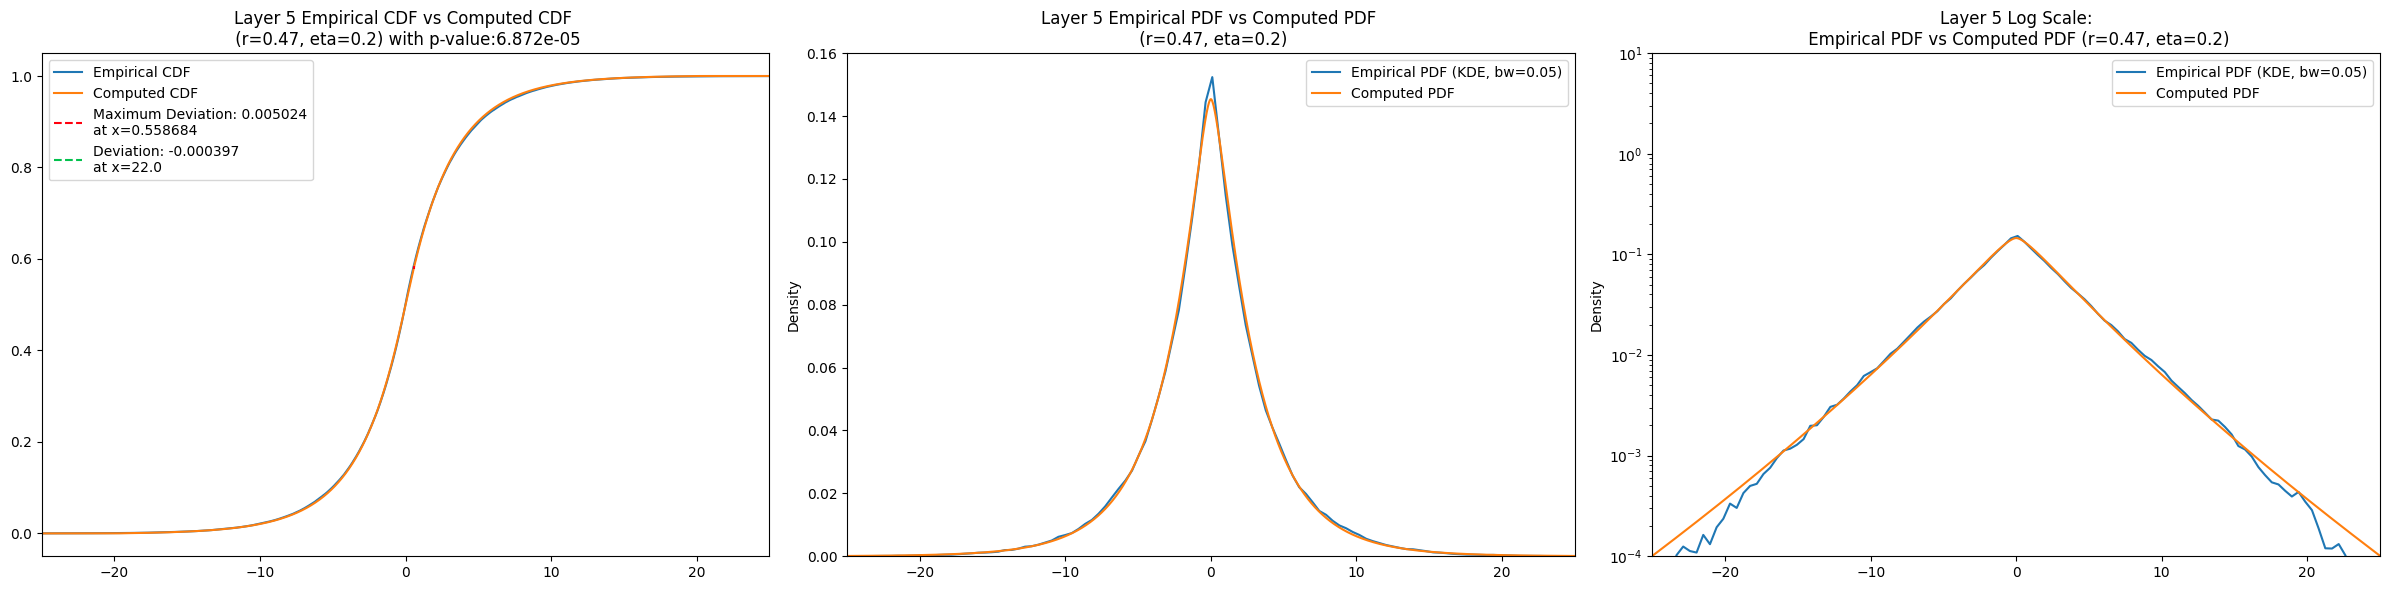

No tail
Chebyshev bound: 7.588825747498706
First CDF value: 1.0410903279315122e-06
Last CDF value: 0.9983483436317541
0, 1 padding bounds: 1000000.0


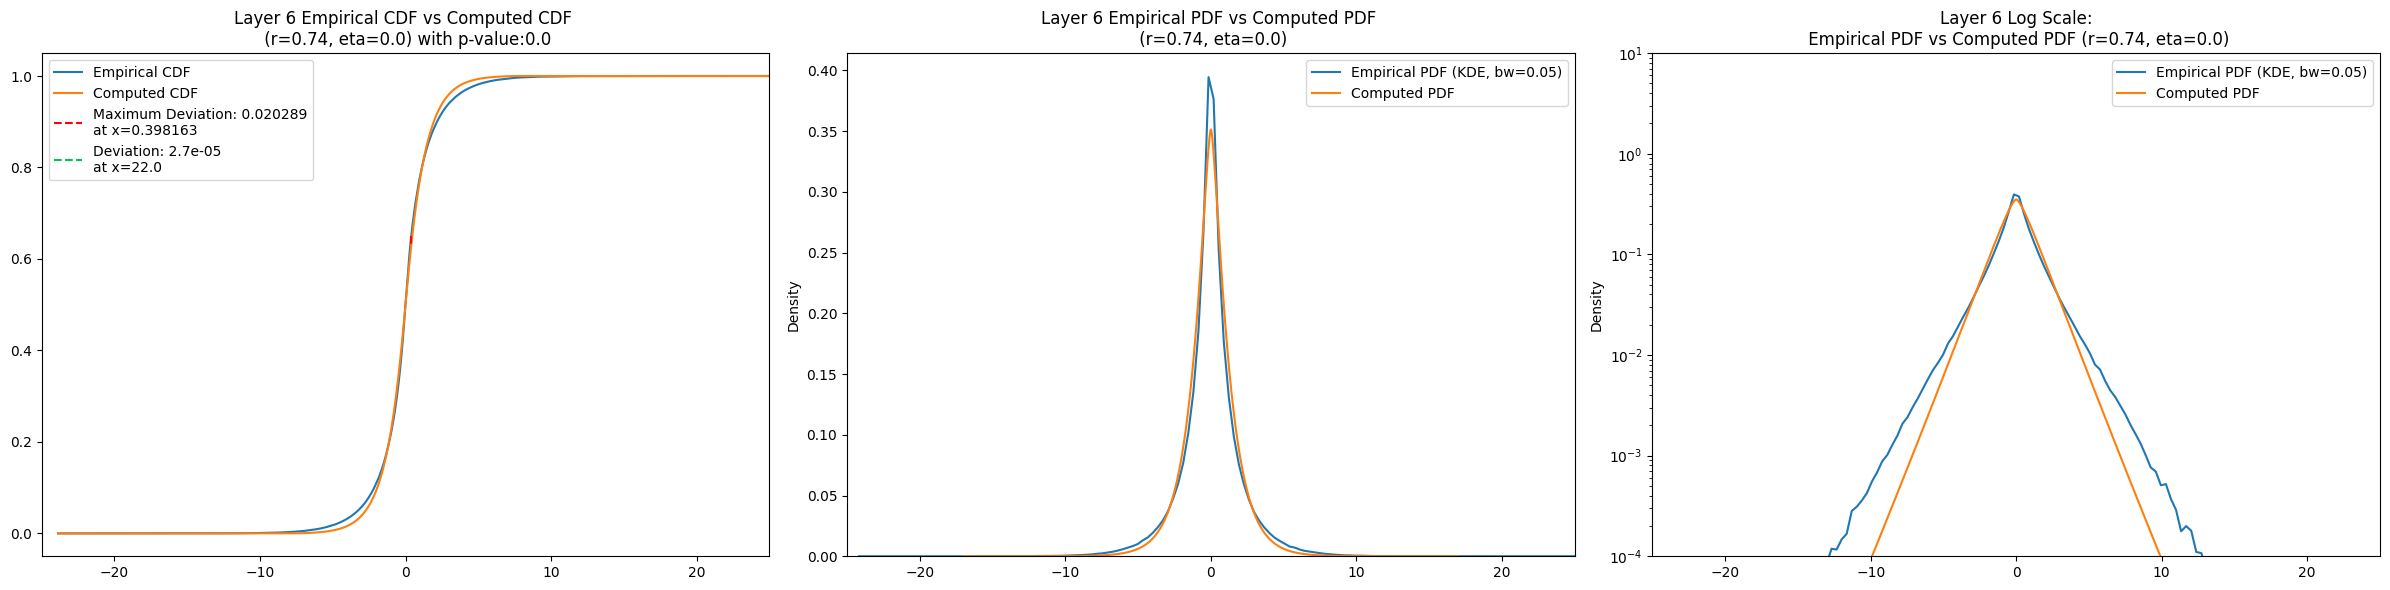

No tail
Chebyshev bound: 3.424770589780717
First CDF value: 1.7854618806850398e-07
Last CDF value: 0.9998619918291485
0, 1 padding bounds: 1000000.0


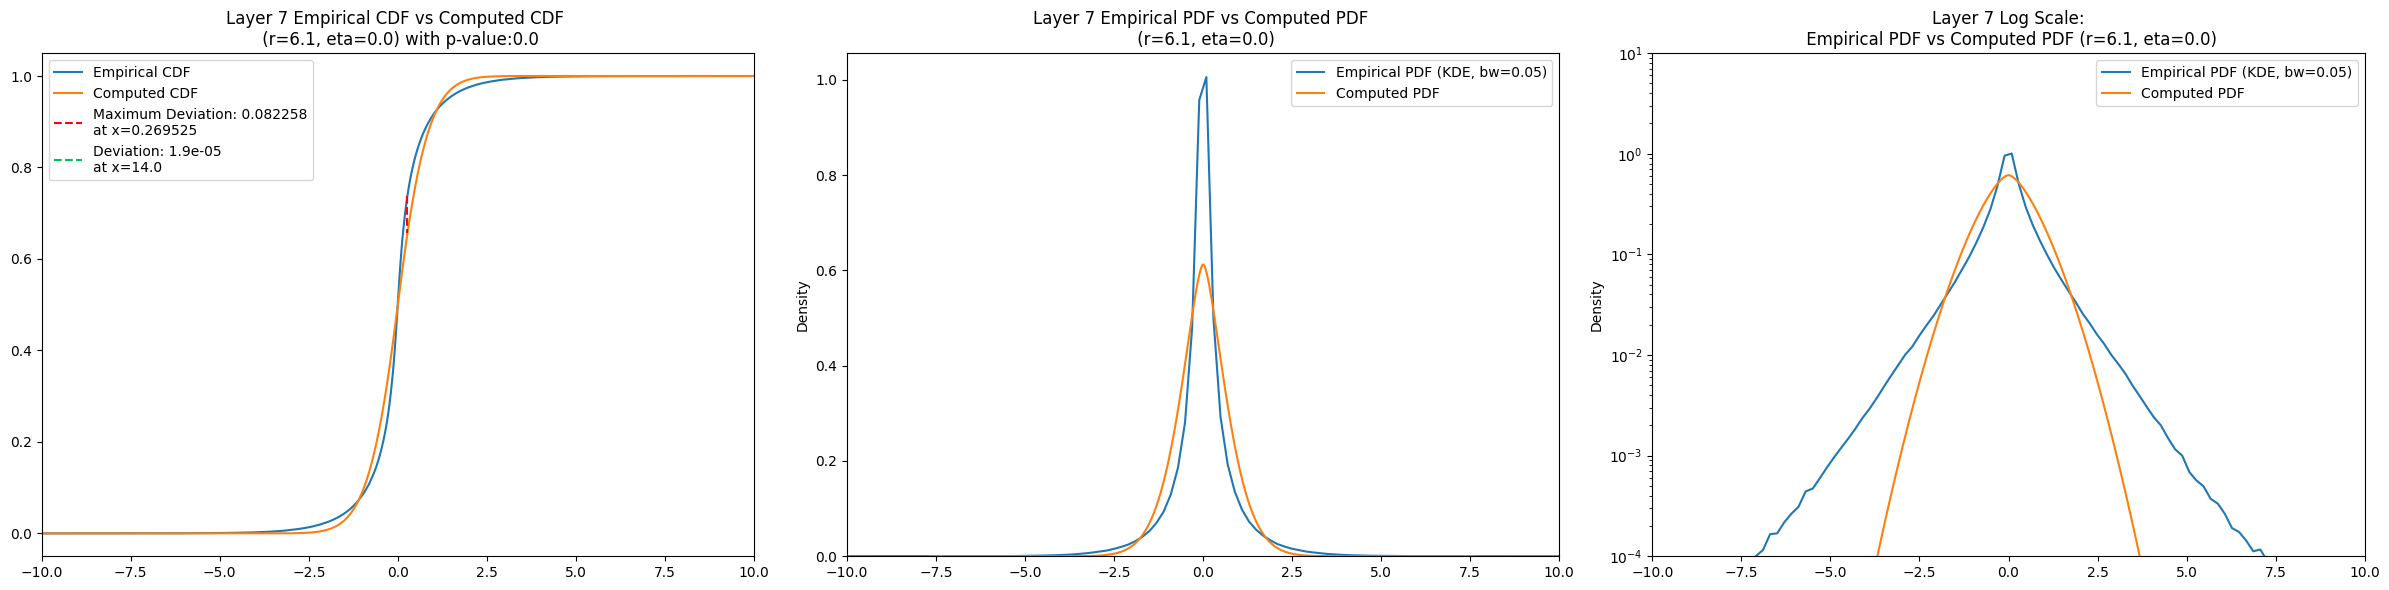

No tail
Chebyshev bound: 3.4258241645696366
First CDF value: 1.7980729374092142e-07
Last CDF value: 0.9998606913119513
0, 1 padding bounds: 1000000.0


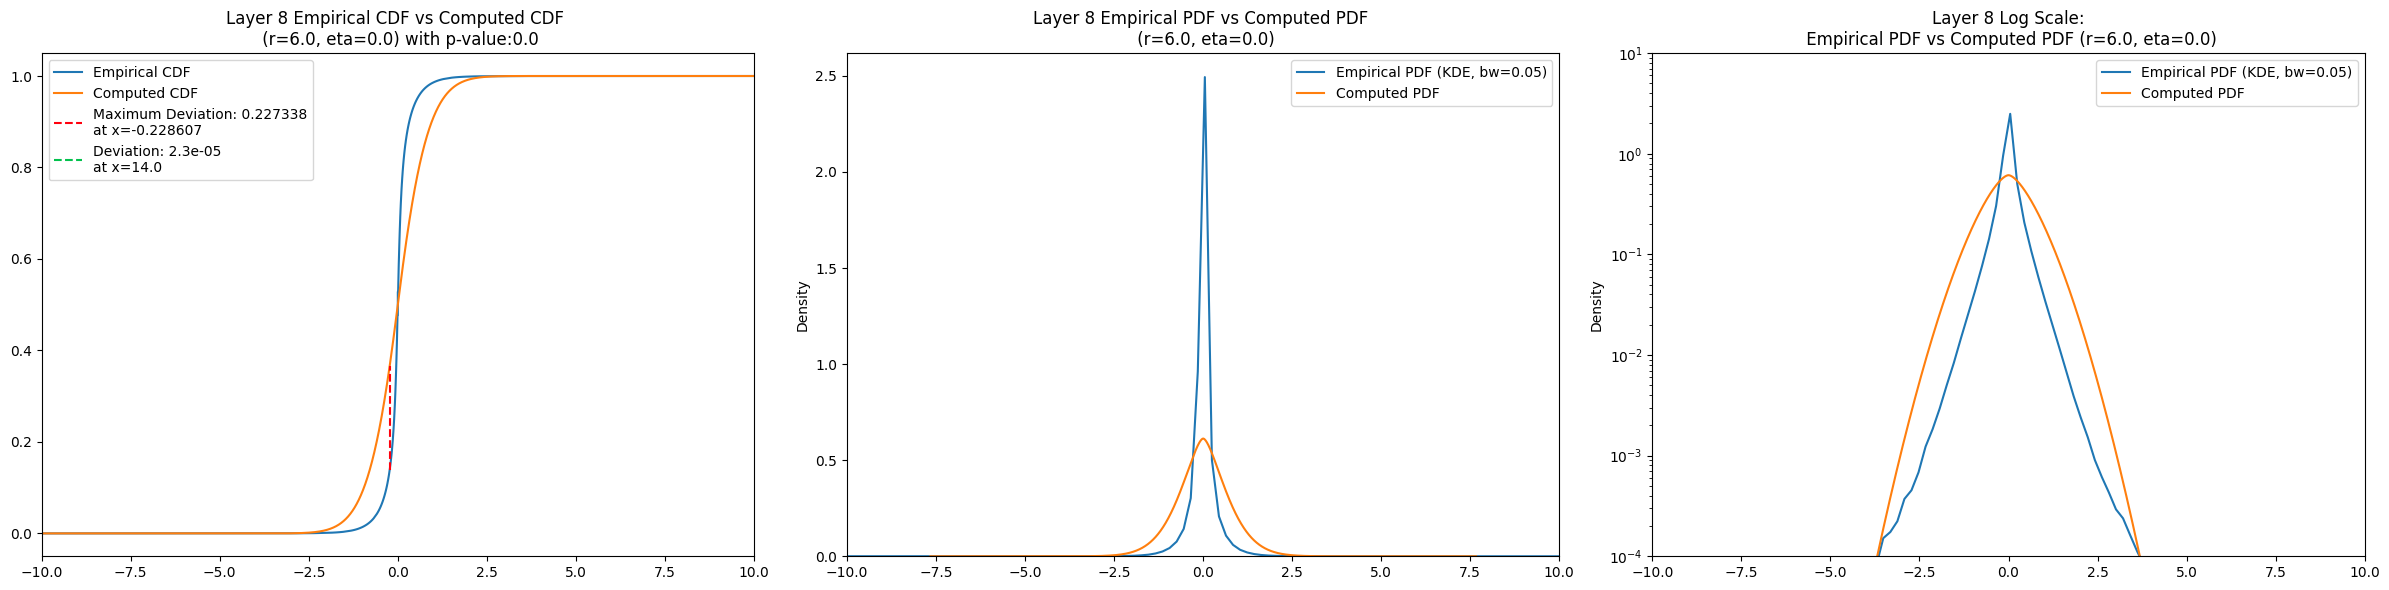

In [ ]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = combine_pickles(f'{GROUP}{group}_10000'),
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [ ]:
SKIP_OPTIMIZE_STEP = True

def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

if SKIP_OPTIMIZE_STEP:
    master_df[f'best_r_scipy'], master_df[f'best_eta_scipy'], master_df[f'kstest_stat_cd_scipy'] =   master_df[f'best_r_d{r_d}'],  master_df[f'best_eta_d{eta_d}'], master_df['kstest_stat_initial']
else:
    for group in np.arange(min_group, max_group+1):
        master_df.loc[group, f'best_r_scipy'], master_df.loc[group, f'best_eta_scipy'], master_df.loc[group, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[group], master_df.loc[group, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,best_r_scipy,best_eta_scipy,kstest_stat_cd_scipy
layer,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,0.39,4.0,0.021670
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,0.44,3.7,0.008143
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,0.44,1.4,0.006270
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,0.47,0.2,0.005235
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,0.74,0.0,0.020505
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,6.10,0.0,0.082279
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,6.00,0.0,0.227356


In [ ]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,9.945980e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,3.658630e-01
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,3.644850e-02
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,...,3.590120,0.030175,2.012920e-161,3.138820,0.002343,2.134870e-01,2.574020,0.010572,3.454100e-20,2.856240e-05
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,...,1.426170,0.042370,0.000000e+00,1.246790,0.014477,1.233750e-148,1.010520,0.017937,5.988230e-228,9.489030e-298
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,...,0.539642,0.052925,0.000000e+00,0.472750,0.025277,0.000000e+00,0.378316,0.026436,0.000000e+00,0.000000e+00
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,...,0.196018,0.056353,0.000000e+00,0.172564,0.029150,0.000000e+00,0.137348,0.028144,0.000000e+00,0.000000e+00


# Examining Tail Behavior

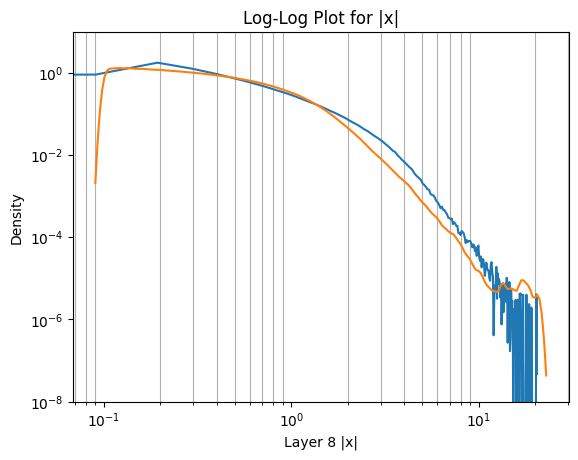

In [ ]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\

TypeError: NDFrame.to_csv() got an unexpected keyword argument 'index_col'

# Results

In [ ]:
#master_df.filter(regex='num_samples|kstest_stat.*')
#master_df.filter(regex='num_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd_scipy,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,
2,0.021670,0.060374,0.024030,0.021670,0.019503,0.036392,0.036305,0.021670,2.166960e-02
3,0.008143,0.037031,0.012029,0.008143,0.010128,0.022665,0.026410,0.008143,8.143188e-03
4,0.006270,0.023245,0.006018,0.006270,0.020474,0.014498,0.018489,0.005811,5.486526e-03
5,0.005235,0.005645,0.003010,0.005235,0.030175,0.002343,0.010572,0.003321,1.373036e-03
6,0.020505,0.020505,0.001505,0.020505,0.042370,0.014477,0.017937,0.019262,8.376645e-04
7,0.082279,0.082279,0.000753,0.082279,0.052925,0.025277,0.026436,0.016792,2.426051e-05
8,0.227356,0.227356,0.000376,0.227356,0.056353,0.029150,0.028144,0.006479,7.677378e-07
